Data Cleaning


In [25]:
import pandas as pd
import datetime 
import numpy as np
# Load the data
data_path = 'data.csv'  # Update with your file path
data = pd.read_csv(data_path)

# Get month from crash date
data['Crash Date'] = pd.to_datetime(data['Crash Date'], errors='coerce')
data['Crash Month'] = data['Crash Date'].dt.month

# Step 1: Drop rows with missing values in essential columns
essential_columns = ['City Town Name', 'Crash Month', 'Crash Severity', 'Light Conditions', 
                     'Road Surface Condition', 'Weather Conditions']
data_cleaned = data.dropna(subset=essential_columns)
data_cleaned=data_cleaned.drop(['Latitude','Longitude','Crash Number'],axis=1)
data_cleaned = data_cleaned.drop(['Crash Date'], axis=1)
                  
# Step 2: Fill missing values in 'Age of Driver' columns with 'Unknown' 
data_cleaned['Age of Driver - Youngest Known'].fillna('Unknown', inplace=True)
data_cleaned['Age of Driver - Oldest Known'].fillna('Unknown', inplace=True)

# Step 3: Optionally drop rows with missing Latitude and Longitude values
#data_cleaned.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# remove unknown data crash result from dataframe
data_cleaned = data_cleaned[data_cleaned['Crash Severity'] != 'Unknown']

# Step 4: Encode categorical columns into numeric codes for modeling
categorical_columns = ['City Town Name', 'Crash Month', 'Crash Severity', 'Age of Driver - Youngest Known', 
                       'Age of Driver - Oldest Known', 'Light Conditions', 
                       'Road Surface Condition', 'Weather Conditions']

for col in categorical_columns:
    data_cleaned[col] = data_cleaned[col].astype('category').cat.codes

# Display the first few rows of the cleaned data
print(data_cleaned.head())
y=data_cleaned['Crash Severity']
data_cleaned=data_cleaned.drop(['Crash Severity'], axis=1)

   City Town Name  Crash Severity  Age of Driver - Youngest Known  \
0              60               2                               4   
1              86               2                               0   
2              60               2                               4   
3             258               2                               5   
4             257               2                               3   

   Age of Driver - Oldest Known  Light Conditions  Road Surface Condition  \
0                             5                 0                       0   
1                             3                 4                       0   
2                             8                 4                       0   
3                             5                 0                       0   
4                             3                 1                       0   

   Weather Conditions  Crash Month  
0                   6            0  
1                   6            0  
2          

Feature Engineering


=== Gini Criterion ===
Accuracy (Gini): 0.7487661696711517
Classification Report (Gini):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.25      0.01      0.02      4705
           2       0.75      0.99      0.86     14501

    accuracy                           0.75     19249
   macro avg       0.33      0.33      0.29     19249
weighted avg       0.63      0.75      0.65     19249

Confusion Matrix (Gini):
 [[    0     1    42]
 [    1    43  4661]
 [    1   130 14370]]

=== Entropy Criterion ===
Accuracy (Entropy): 0.7487142189204634
Classification Report (Entropy):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.21      0.01      0.01      4705
           2       0.75      0.99      0.86     14501

    accuracy                           0.75     19249
   macro avg       0.32      0.33      0.29     19249
weighted avg 

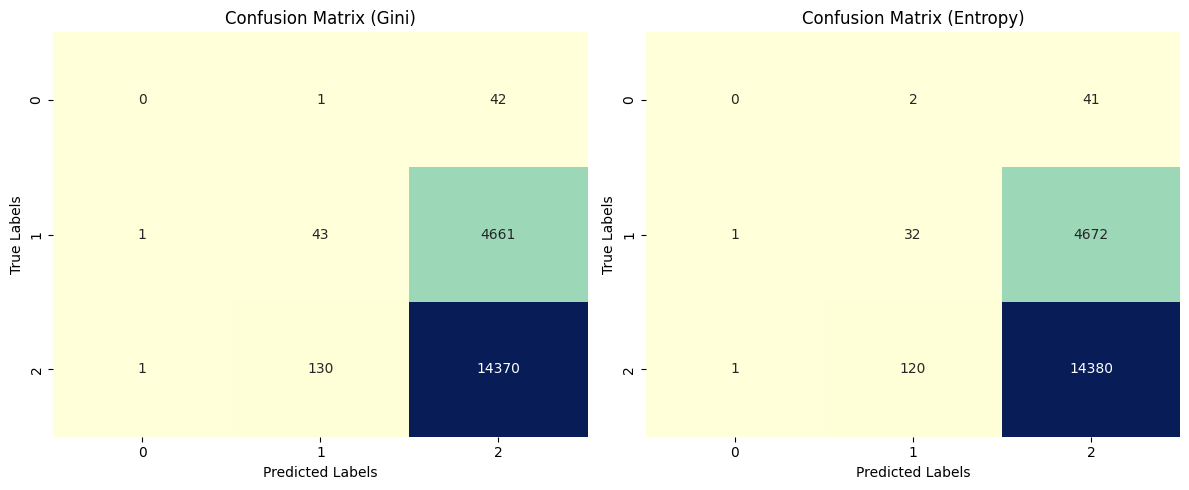

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Separate features and target
#y = data_cleaned['Crash Severity']
#X = data_cleaned.drop(['Crash Severity'], axis=1)
X=data_cleaned

# Step 2: Convert all non-numeric columns to strings and apply Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    X[column] = X[column].astype(str)
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cweights = {0:0.1, 1:0.25, 2:0.75}

# Step 4: Train Decision Tree with Gini criterion
model_gini = DecisionTreeClassifier(criterion="gini", max_depth=12, random_state=42, class_weight=cweights)
model_gini.fit(X_train, y_train)
y_pred_gini = model_gini.predict(X_test)

# Step 5: Train Decision Tree with Entropy criterion
model_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=12, random_state=42, class_weight=cweights)
model_entropy.fit(X_train, y_train)
y_pred_entropy = model_entropy.predict(X_test)

# Step 6: Model evaluation and comparison
print("=== Gini Criterion ===")
print("Accuracy (Gini):", accuracy_score(y_test, y_pred_gini))
print("Classification Report (Gini):\n", classification_report(y_test, y_pred_gini))
print("Confusion Matrix (Gini):\n", confusion_matrix(y_test, y_pred_gini))

print("\n=== Entropy Criterion ===")
print("Accuracy (Entropy):", accuracy_score(y_test, y_pred_entropy))
print("Classification Report (Entropy):\n", classification_report(y_test, y_pred_entropy))
print("Confusion Matrix (Entropy):\n", confusion_matrix(y_test, y_pred_entropy))

# Step 7: Visualize Confusion Matrices with Heatmaps
# Gini Confusion Matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_gini), annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Confusion Matrix (Gini)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Entropy Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_entropy), annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Confusion Matrix (Entropy)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.tight_layout()
plt.show()



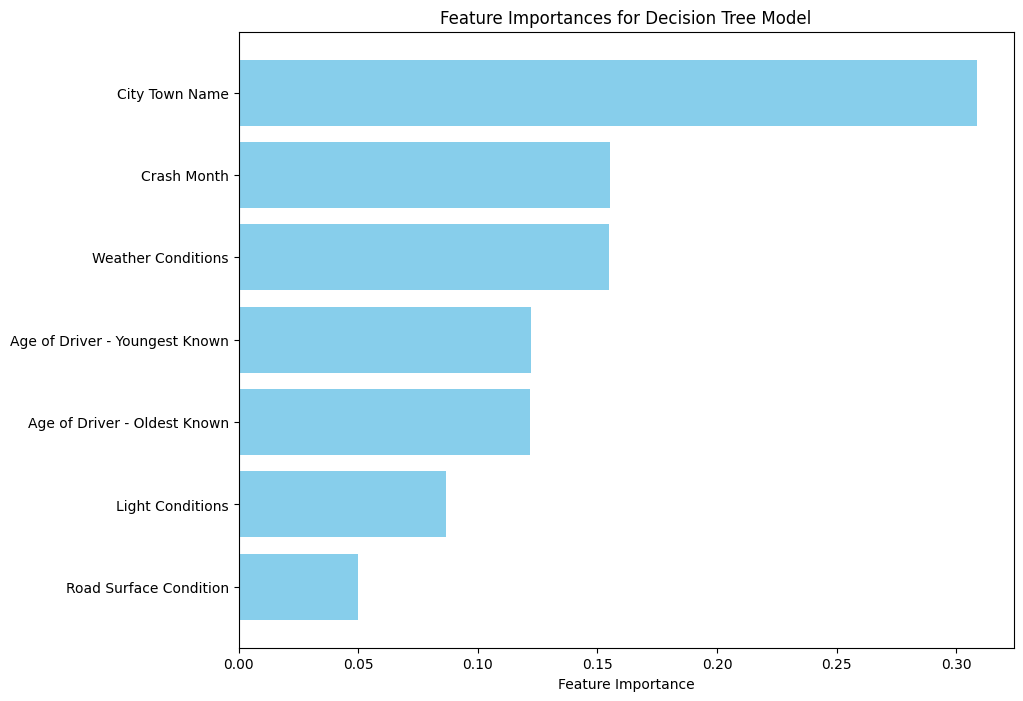

In [27]:
import matplotlib.pyplot as plt

# Assuming data_cleaned.columns and model_gini.feature_importances_ are available
def plot_feature_importances(feature_names, importances):
    feature_importance_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Unzip the sorted features
    sorted_feature_names, sorted_importances = zip(*sorted_features)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title("Feature Importances for Decision Tree Model")
    plt.gca().invert_yaxis()
    plt.show()

# Call the function with your data
plot_feature_importances(data_cleaned.columns, model_gini.feature_importances_)

In [28]:
print(model_gini.feature_importances_)
print(model_entropy.feature_importances_)
print(dict(zip(data_cleaned.columns, model_gini.feature_importances_)))

[0.30860197 0.12241102 0.12181388 0.08689956 0.04989126 0.15500654
 0.15537577]
[0.35780671 0.11981529 0.128357   0.07467894 0.04044137 0.14573346
 0.13316723]
{'City Town Name': 0.30860197389391775, 'Age of Driver - Youngest Known': 0.12241102067626303, 'Age of Driver - Oldest Known': 0.12181387697343184, 'Light Conditions': 0.08689955806310916, 'Road Surface Condition': 0.04989125866974964, 'Weather Conditions': 0.15500654484551324, 'Crash Month': 0.15537576687801535}


In [29]:
#from sklearn import tree
#tree.plot_tree(model_gini, proportion=True)
#plt.show()